<a href="https://colab.research.google.com/github/BachiLi/redner/blob/master/tutorials/material_and_lights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This tutorial explains how material, texturing, and light sources works in redner.

In [1]:
!pip install --upgrade redner-gpu

     |████████████████████████████████| 33.1MB 1.3MB/s 


In [0]:
import torch
import pyredner

This time we'll use a simpler geometry -- a sphere. We can use `generate_sphere` to procedurally generate the triangle mesh geometry of a sphere.

In [0]:
# The steps arguments decide how many triangles are used to represent the sphere.
vertices, indices, uvs, normals = pyredner.generate_sphere(theta_steps = 64, phi_steps = 128)

Now we have the triangle mesh, we need to assign a material to the mesh. redner `Material` has three main parameters: `diffuse_reflectance`, `specular_reflectance`, and `roughness`, which describes a linear blend between a [Lambertian](https://en.wikipedia.org/wiki/Lambertian_reflectance) and a [microfacet](http://www.pbr-book.org/3ed-2018/Reflection_Models/Microfacet_Models.html) [BRDF](https://en.wikipedia.org/wiki/Bidirectional_reflectance_distribution_function), with a Phong distribution function and [Schlick's Fresnel approximation](https://en.wikipedia.org/wiki/Schlick%27s_approximation). You can pass in PyTorch tensors to them. If the tensors are 1-dimensional (size 3 for diffuse and specular reflectances, and size 1 for roughness), the parameters are constant across the object. If the tensors are 3-dimensional (\[height, width, 3\] for diffuse and specular reflectances, \[height, width, 1\] for roughness), the parameters are mapped to the object using the `uv` map. We start by defining a boring gray diffuse material.

In [0]:
m = pyredner.Material(diffuse_reflectance = torch.tensor((0.5, 0.5, 0.5), device = pyredner.get_device()))

Next we combine the geometry and material into an object, generate a camera, combine them into a scene.

In [0]:
obj = pyredner.Object(vertices = vertices, indices = indices, uvs = uvs, normals = normals, material = m)
cam = pyredner.automatic_camera_placement([obj], resolution = (480, 640))
scene = pyredner.Scene(objects = [obj], camera = cam)

Let's try to visualize the scene.

Scene construction, time: 22.17849 s
Forward pass, time: 0.05525 s


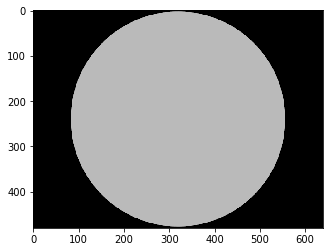

In [6]:
img = pyredner.render_albedo(scene)
# Visualize img
from matplotlib.pyplot import imshow
%matplotlib inline
imshow(torch.pow(img, 1.0/2.2).cpu())

And now let's try to render it using the physically-based rendering mode.

Scene construction, time: 0.03351 s
Forward pass, time: 0.03592 s


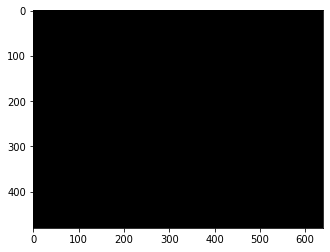

In [7]:
img = pyredner.render_pathtracing(scene)
imshow(torch.pow(img, 1.0/2.2).cpu())

Oops! The image is black! This is because there is no light sources in the scene, so the sphere can not reflect any photons to our camera. There are two types of light sources in the physically-based rendering mode of redner -- area lights and environment maps. An area light is described by a geometry with an intensity parameter, while an environment map is an image representing directional light distribution that are infinitely far away from the scene. For area lights, redner provides an utility function `generate_quad_light` that can generate a quad light source facing a direction. The size of the light source determines the size of the [penumbra](https://en.wikipedia.org/wiki/Umbra,_penumbra_and_antumbra) of the shadow. Also the larger the light source, usually more Monte Carlo samples would be required to generate a noiseless image.

Scene construction, time: 0.03524 s
Forward pass, time: 0.08065 s


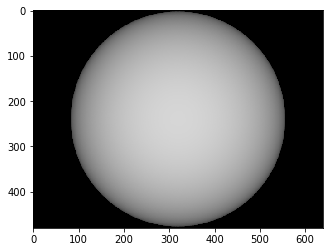

In [8]:
# Put the light source behind the camera, so that it does not block the view.
light = pyredner.generate_quad_light(position = cam.position + torch.tensor([0.0, 0.0, -1.0]),
                                     look_at = torch.zeros(3),
                                     size = torch.tensor([0.1, 0.1]),
                                     intensity = torch.tensor([5000.0, 5000.0, 5000.0]))
scene = pyredner.Scene(objects = [obj, light], camera = cam)
img = pyredner.render_pathtracing(scene)
imshow(torch.pow(img, 1.0/2.2).cpu())

In this tutorial however, we will stick with the [environment maps](https://en.wikipedia.org/wiki/Image-based_lighting), which is an easy way to setup realistic lighting without having to fully model the geometry of the light sources. We will download an environment map of the Grace Cathedral from [USC's Vision & Graphics Lab's fantastic website](https://vgl.ict.usc.edu/Data/HighResProbes/).

In [0]:
import requests
r = requests.get('https://vgl.ict.usc.edu/Data/HighResProbes/probes/grace-new.exr')
with open('grace-new.exr', 'wb') as outfile:
    outfile.write(r.content)

The image is in the [OpenEXR](https://en.wikipedia.org/wiki/OpenEXR) format for capturing the [high-dynamic range](https://en.wikipedia.org/wiki/High-dynamic-range_imaging) of the radiance, and redner provides an EXR reader for reading these formats.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


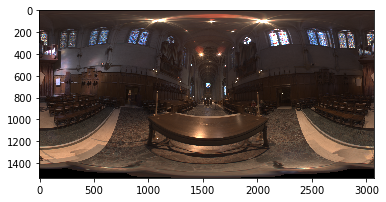

In [10]:
envmap_img = pyredner.imread('grace-new.exr')
imshow(torch.pow(envmap_img, 1/2.2).cpu())

You can use the envmap in redner by setting the `envmap` argument in a redner Scene to a `pyredner.EnvironmentMap`.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scene construction, time: 0.03161 s
Forward pass, time: 0.07021 s


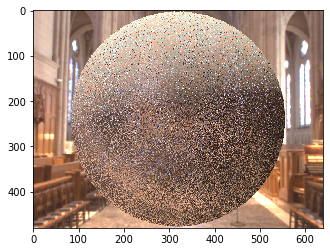

In [11]:
envmap = pyredner.EnvironmentMap(envmap_img * 10.0) # *10 to make the image brighter
scene = pyredner.Scene(objects = [obj], camera = cam, envmap=envmap)
img = pyredner.render_pathtracing(scene)
imshow(torch.pow(img, 1.0/2.2).cpu())

As you can see the image is quite noisy with the low sample count. Apart from increasing the sample count, blurring or downsampling the environment map also makes the image less noisy.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scene construction, time: 0.02911 s
Forward pass, time: 0.07019 s


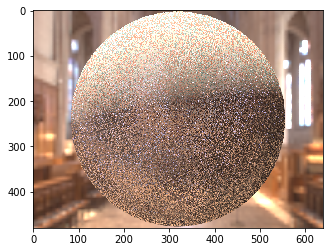

In [12]:
# Downsample the environment map
target_res = [int(envmap_img.shape[0] / 4), int(envmap_img.shape[1] / 4)]
img = envmap_img.permute(2, 0, 1) # HWC -> CHW
img = img.unsqueeze(0) # CHW -> NCHW
img = torch.nn.functional.interpolate(img, size = target_res, mode = 'area')
img = img.squeeze(dim = 0) # NCHW -> CHW
img = img.permute(1, 2, 0)
envmap_img_lowres = img
# Render
envmap = pyredner.EnvironmentMap(envmap_img_lowres * 10.0) # *10 to make the image brighter
scene = pyredner.Scene(objects = [obj], camera = cam, envmap=envmap)
img = pyredner.render_pathtracing(scene)
imshow(torch.pow(img, 1.0/2.2).cpu())

Scene construction, time: 0.02905 s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Forward pass, time: 0.68931 s


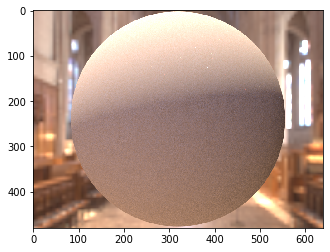

In [13]:
# Render with more samples
img = pyredner.render_pathtracing(scene, num_samples = (128, 4))
imshow(torch.pow(img, 1.0/2.2).cpu())

Looks good! Now let's play with the materials a bit. So far we've only used a boring gray diffuse material. Let's play with the specular reflectance and roughness a bit. In real life, the small variation of the surfaces affects how *concentrated* the light reflections are. A smooth surface would mostly reflect photons to a fixed direction given a incident angle, while a rough surface scatters the photon to random directions. The roughness parameter captures this phenomonon. The lower the roughness is, the more the specular reflection looks like a mirror, and the higher the roughness is, the more the specular reflection looks like a diffuse matte.

Scene construction, time: 0.02918 s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Forward pass, time: 0.72259 s


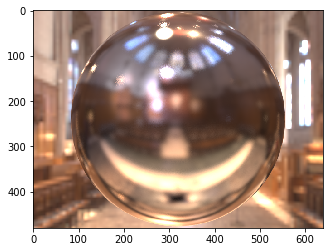

In [14]:
# Let's try a small roughness first.
obj.material = pyredner.Material(specular_reflectance = torch.tensor((0.5, 0.5, 0.5), device = pyredner.get_device()),
                                 roughness = torch.tensor([0.001], device = pyredner.get_device()))
scene = pyredner.Scene(objects = [obj], camera = cam, envmap=envmap)
img = pyredner.render_pathtracing(scene, num_samples = (128, 4))
imshow(torch.pow(img, 1.0/2.2).cpu())

Scene construction, time: 0.02900 s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Forward pass, time: 0.73782 s


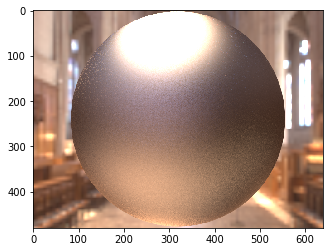

In [15]:
# A larger roughness gives a "glossy" look
obj.material = pyredner.Material(specular_reflectance = torch.tensor((0.5, 0.5, 0.5), device = pyredner.get_device()),
                                 roughness = torch.tensor([0.1], device = pyredner.get_device()))
scene = pyredner.Scene(objects = [obj], camera = cam, envmap=envmap)
img = pyredner.render_pathtracing(scene, num_samples = (128, 4))
imshow(torch.pow(img, 1.0/2.2).cpu())

Scene construction, time: 0.02875 s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Forward pass, time: 0.71715 s


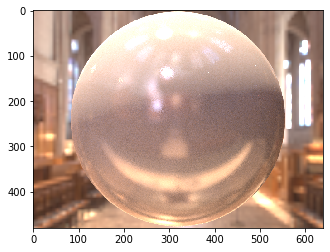

In [16]:
# We can also mix diffuse and specular reflectance. Plastics and car paints are well described by this mixture model.
obj.material = pyredner.Material(diffuse_reflectance = torch.tensor((0.5, 0.5, 0.5), device = pyredner.get_device()),
                                 specular_reflectance = torch.tensor((0.2, 0.2, 0.2), device = pyredner.get_device()),
                                 roughness = torch.tensor([0.001], device = pyredner.get_device()))
scene = pyredner.Scene(objects = [obj], camera = cam, envmap=envmap)
img = pyredner.render_pathtracing(scene, num_samples = (128, 4))
imshow(torch.pow(img, 1.0/2.2).cpu())

Redner also supports texture rendering. Let's try adding textures to the sphere. We'll use a checkerboard texture.

Scene construction, time: 0.02883 s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Forward pass, time: 0.70937 s


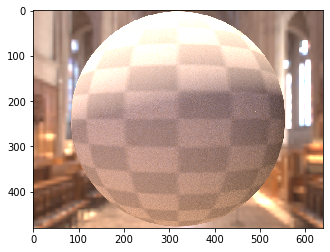

In [17]:
import urllib
urllib.request.urlretrieve('https://github.com/BachiLi/redner/raw/master/tests/scenes/textures/default.png', 'default.png')
texture = pyredner.imread('default.png')
obj.material = pyredner.Material(diffuse_reflectance = texture)
scene = pyredner.Scene(objects = [obj], camera = cam, envmap=envmap)
img = pyredner.render_pathtracing(scene, num_samples = (128, 4))
imshow(torch.pow(img, 1.0/2.2).cpu())

To adjust the granularity of the checkerboard, we can use a parameter `uv_scale` in `pyredner.Texture`.

Scene construction, time: 0.02866 s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Forward pass, time: 0.71113 s


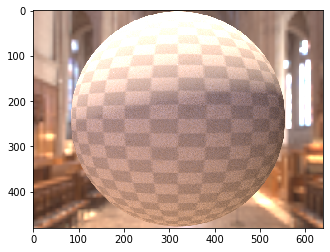

In [18]:
obj.material = pyredner.Material(diffuse_reflectance = pyredner.Texture(texels=pyredner.imread('default.png'), uv_scale=torch.tensor((2.0, 2.0))))
scene = pyredner.Scene(objects = [obj], camera = cam, envmap=envmap)
img = pyredner.render_pathtracing(scene, num_samples = (128, 4))
imshow(torch.pow(img, 1.0/2.2).cpu())

You can also use texture for roughness.

Scene construction, time: 0.02920 s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Forward pass, time: 0.76763 s


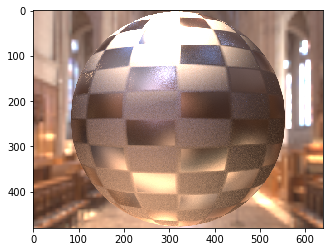

In [19]:
texture = texture[:, :, 0:1]
texture = torch.where(texture < 0.7, torch.ones(texture.shape) * 0.01, torch.ones(texture.shape) * 0.2)
obj.material = pyredner.Material(specular_reflectance = torch.tensor((0.5, 0.5, 0.5), device = pyredner.get_device()),
                                 roughness = texture)
scene = pyredner.Scene(objects = [obj], camera = cam, envmap=envmap)
img = pyredner.render_pathtracing(scene, num_samples = (128, 4))
imshow(torch.pow(img, 1.0/2.2).cpu())

Redner also supports [normal mapping](https://en.wikipedia.org/wiki/Normal_mapping). Normal map adjusts the local normal of the geometry to add more details to the material. Just set the `normal_map` argument in `Material` to some texture.

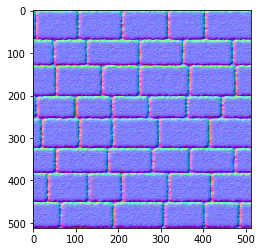

In [20]:
import urllib
# Downloaded from https://worldwidemuseum.wordpress.com/2013/01/13/carriage-plates-step-2/
urllib.request.urlretrieve('https://github.com/BachiLi/redner/raw/master/tests/scenes/brick_normal.jpg', 'brick_normal.png')
normal_map = pyredner.imread('brick_normal.png', gamma=1.0) # Normal maps are usually not Gamma compressed.
imshow(normal_map.cpu())

Scene construction, time: 0.02919 s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Forward pass, time: 0.75747 s


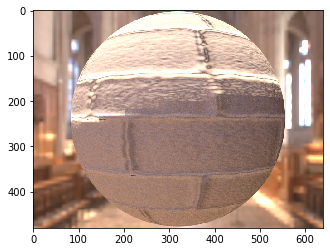

In [21]:
obj.material = pyredner.Material(diffuse_reflectance = torch.tensor((0.5, 0.5, 0.5), device = pyredner.get_device()),
                                 normal_map = normal_map)
scene = pyredner.Scene(objects = [obj], camera = cam, envmap=envmap)
img = pyredner.render_pathtracing(scene, num_samples = (128, 4))
imshow(torch.pow(img, 1.0/2.2).cpu())

For deep learning types of applications, it is often desirable to output an image with more than 3 channels (since overparametrization is good!). For this redner provides a `generic_texture` field, that can takes textures with arbitrary number of channels. You can then use `render_g_buffer` to render the texture.

In [22]:
obj.material = pyredner.Material(generic_texture=torch.rand([128, 128, 16], device = pyredner.get_device()))
scene = pyredner.Scene(objects = [obj], camera = cam)
img = pyredner.render_g_buffer(scene, [pyredner.channels.generic_texture])
print(img.shape)

Scene construction, time: 0.03033 s
Forward pass, time: 0.03063 s
torch.Size([480, 640, 16])


Generic textures can also be useful for implementing your own local shading models. For example, you can store [spherical harmonics](https://en.wikipedia.org/wiki/Spherical_harmonics) coefficients in the generic textures, compute the closed-form solution of the convolution of the SH coefficients with some environment map's projection to SH per-pixel, and output an image.

Finally, redner also supports per-vertex color. This is less recommended since it is difficult to properly [filter](https://en.wikipedia.org/wiki/Mipmap) vertex color, also it doesn't make much sense signal processing wise to use the same sampling rate for geometry and material. However in some applications such as [3D morphable model](https://gravis.dmi.unibas.ch/publications/Sigg99/morphmod2.pdf) the existing data are already stored in vertex and the conversion is tedious, so we provide the vertex color functionality. To use it set `use_vertex_color=True` in `Material` and supply vertex color in the `colors` field of `Object`. This mode currently only supports Lambertian materials.

Scene construction, time: 0.02888 s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Forward pass, time: 0.69078 s


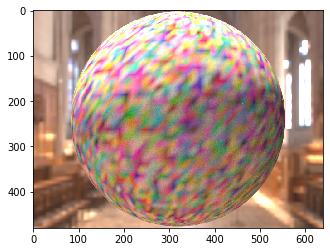

In [23]:
obj.material = pyredner.Material(use_vertex_color=True)
obj.colors = torch.rand_like(obj.vertices) # random color
scene = pyredner.Scene(objects = [obj], camera = cam, envmap=envmap)
img = pyredner.render_pathtracing(scene, num_samples = (128, 4))
imshow(torch.pow(img, 1.0/2.2).cpu())